In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from feature_engine.outliers import OutlierTrimmer

rawdata = pd.read_csv('adverts.csv')

sample = rawdata.sample(5)

rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [122]:
rawdata['vehicle_condition'].replace({'NEW': 1, 'USED': 0}, inplace=True)
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  int64  
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 34.1+ MB


C:\Users\galac\AppData\Local\Temp\ipykernel_9172\4144774959.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


C:\Users\galac\AppData\Local\Temp\ipykernel_9172\4144774959.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


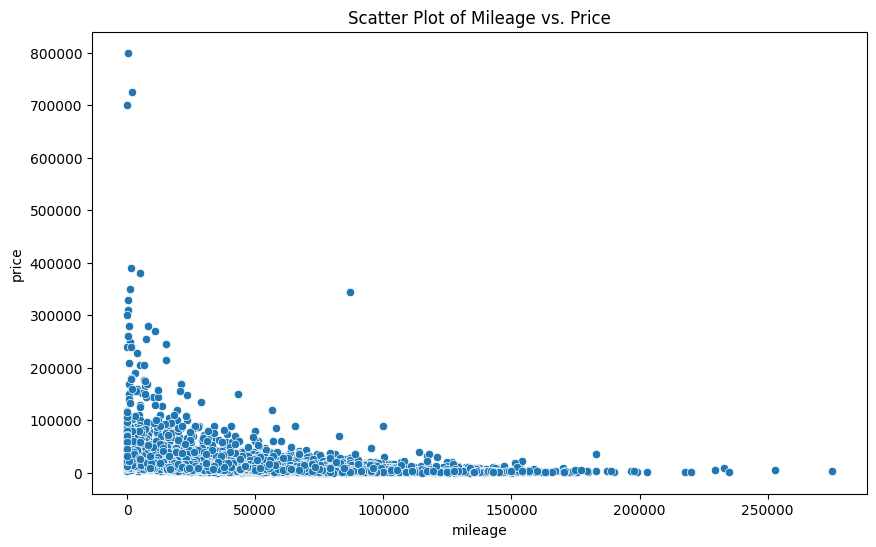

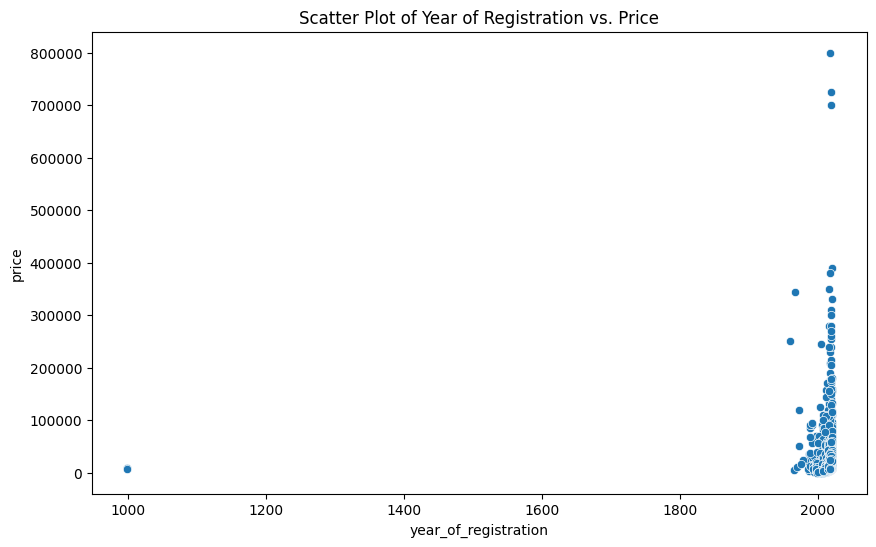

In [123]:
sample = rawdata.sample(10000)
#sns.histplot(sample['mileage'])
#plt.show()

#sns.histplot(sample['year_of_registration'])
#plt.show()

#sns.histplot(sample['price'])
#plt.show()

#sns.boxplot(sample['price'])
#plt.show()

#sns.barplot(sample['standard_colour'])
#plt.show()
#sns.barplot(sample['standard_make'])
#plt.show()
#sns.barplot(sample['standard_model'])
#plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='mileage', y='price', data=sample)
plt.title('Scatter Plot of Mileage vs. Price')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='year_of_registration', y='price', data=sample)
plt.title('Scatter Plot of Year of Registration vs. Price')
plt.show()

In [124]:
# select data points that heavily influence sell price
sdata = rawdata[['mileage', 'standard_make', 'vehicle_condition', 'year_of_registration', 'price', 'fuel_type']]

# Get the current year
current_year = datetime.now().year

# Set 'year_of_registration' to the current year if 'vehicle_condition' is True
sdata.loc[sdata['vehicle_condition'] == True, 'year_of_registration'] = current_year

# remove cars registered before 1910
sdata = sdata[(sdata['year_of_registration'] >= 1910)]

# remove cars with no reported fuel type
sdata = sdata.dropna(subset=['fuel_type'])

In [125]:
# find the average price for each maufacturer to score them
avgMan = sdata.groupby('standard_make')['price'].mean()
avgMan = avgMan.rename('average_price')
avgMan = avgMan.to_frame()
avgMan = avgMan.sort_values('average_price')
avgMan['rank'] = avgMan['average_price'].rank(ascending=False, method='dense').astype(int)
rank_dict = avgMan['rank'].to_dict()
sdata['standard_make'] = sdata['standard_make'].map(rank_dict)

# find the average price for each fuel type
avgFuel = sdata.groupby('fuel_type')['price'].mean()
avgFuel = avgFuel.rename('average_price')
avgFuel = avgFuel.to_frame()
avgFuel = avgFuel.sort_values('average_price')
avgFuel['rank'] = avgFuel['average_price'].rank(ascending=False, method='dense').astype(int)
rank_dict = avgFuel['rank'].to_dict()
sdata['fuel_type'] = sdata['fuel_type'].map(rank_dict)

In [126]:
sdata['age'] = current_year - sdata['year_of_registration']
sdata['mileage'] = np.where(pd.isna(sdata['mileage']), 0, sdata['mileage'])
sdata['mileage'] = sdata['mileage'].astype(int)

sdata['mileage_per_year'] = np.where(sdata['age'] == 0, 0, sdata['mileage'] / sdata['age'])

sdata['mileage_per_year'] = sdata['mileage_per_year']
sdata = sdata.drop('year_of_registration', axis=1)

# logging for debugging
#avgMan.to_csv('averagepricesmanufacturer.csv', index=True)
#avgFuel.to_csv('averagepricesfuel.csv', index=True)

#sdata.to_csv('cleaned_data.csv', index=False)

In [127]:
trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5, variables=['price'])
sdata_trimmed = trimmer.fit_transform(sdata)

newcars = sdata.loc[sdata['vehicle_condition'] == 1]
oldcars = sdata.loc[sdata['vehicle_condition'] == 0]

In [128]:
#sns.pairplot(newcars[['mileage', 'age', 'mileage_per_year', 'price']])
#plt.show()

#sns.pairplot(oldcars[['mileage', 'age', 'mileage_per_year', 'price']])
#plt.show()

#plt.figure(figsize=(12, 8))
#sns.heatmap(sdata.corr(), annot=True, cmap='coolwarm')
#plt.title('Correlation Heatmap')
#plt.show()

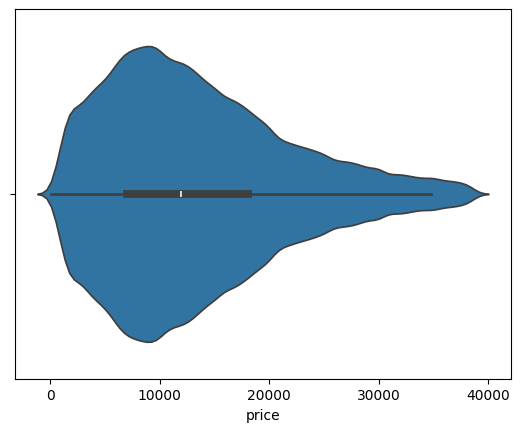

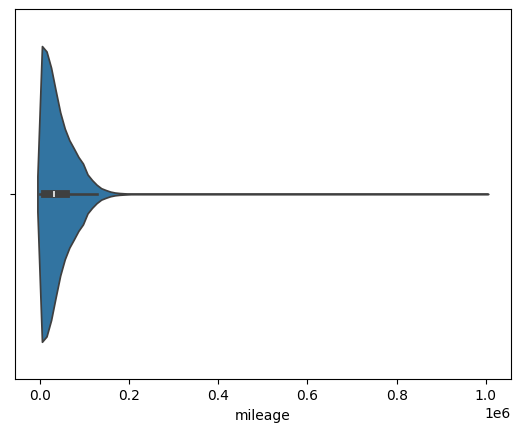

In [129]:
sns.violinplot(x=sdata_trimmed['price'])
plt.show()

sns.violinplot(x=sdata_trimmed['mileage'])
plt.show()

In [130]:
#sns.pairplot(sdata_trimmed[['mileage', 'mileage_per_year', 'age', 'standard_make', 'fuel_type', 'price']])
#plt.show()

In [131]:
correlation_matrix = sdata_trimmed.corr()
print(correlation_matrix['price'].sort_values(ascending=False))

price                1.000000
vehicle_condition    0.303014
fuel_type           -0.245027
mileage_per_year    -0.432734
standard_make       -0.443947
mileage             -0.548545
age                 -0.597189
Name: price, dtype: float64


In [132]:
X = sdata_trimmed.drop('price', axis=1)
y = sdata_trimmed['price']

X.head()

,mileage,standard_make,vehicle_condition,fuel_type,age,mileage_per_year
1,108230,39,0,6,14.0,7730.714286
2,7800,67,0,7,8.0,975.000000
3,45000,90,0,6,9.0,5000.000000
4,64000,28,0,6,10.0,6400.000000
5,16000,51,0,7,8.0,2000.000000


In [133]:
# -----------------------------------------------------------------------
# Linear Regression Model
# -----------------------------------------------------------------------

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict

# Sample a subset of data for hyperparameter tuning
sample_chunk = sdata_trimmed.sample(frac=0.1)
X_sample = sample_chunk.drop('price', axis=1)
y_sample = sample_chunk['price']

# Remove outliers beyond 3 standard deviations
z_scores = np.abs((X_sample - X_sample.mean()) / X_sample.std())
X_sample = X_sample[(z_scores < 3).all(axis=1)]
y_sample = y_sample[(z_scores < 3).all(axis=1)]


Cross-Validation MSE: 16034024.893294161
Cross-Validation R^2: 0.7356802576575371


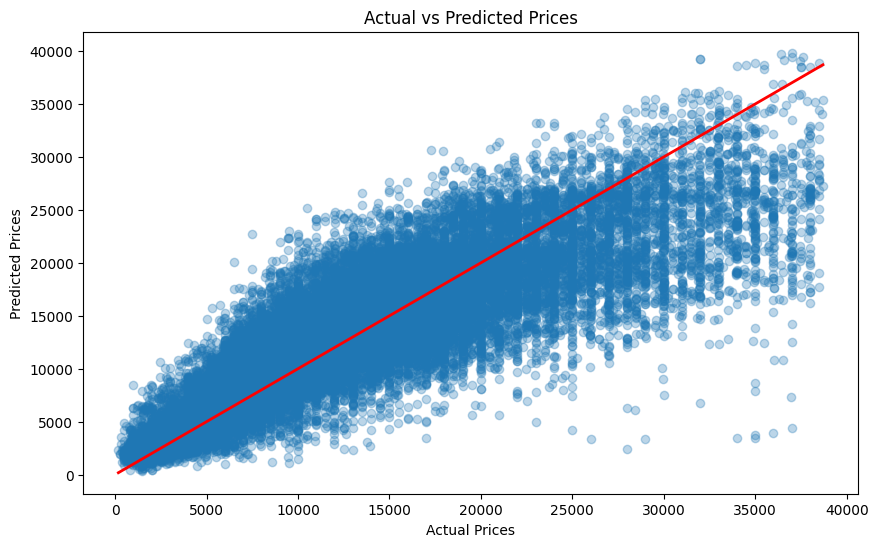

In [134]:
# Add polynomial features
poly = PolynomialFeatures(degree=2)
X_poly_sample = poly.fit_transform(X_sample)

# create model
linear_model = LinearRegression()

# Cross-Validation
mse_scorer = make_scorer(mean_squared_error)
cross_val_mse = cross_val_score(linear_model, X_poly_sample, y_sample, cv=5, scoring=mse_scorer)
cross_val_r2 = cross_val_score(linear_model, X_poly_sample, y_sample, cv=5, scoring='r2')

print(f"Cross-Validation MSE: {cross_val_mse.mean()}")
print(f"Cross-Validation R^2: {cross_val_r2.mean()}")

# Cross-Validation Predictions for Actual vs. Predicted Plot
y_pred_cv = cross_val_predict(linear_model, X_poly_sample, y_sample, cv=5)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_sample, y_pred_cv, alpha=0.3)
plt.plot([y_sample.min(), y_sample.max()], [y_sample.min(), y_sample.max()], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define chunk size
chunk_size = 10000

# Initialize accumulators for metrics
accumulated_mse = 0
accumulated_r2 = 0
num_chunks = 0


# Process data in chunks
for i in range(0, len(sdata_trimmed), chunk_size):
    chunk = sdata_trimmed.iloc[i:i+chunk_size]
    X = chunk.drop('price', axis=1)
    y = chunk['price']
    
    # Remove outliers beyond 3 standard deviations
    z_scores = np.abs((X - X.mean()) / X.std())
    X = X[(z_scores < 3).all(axis=1)]
    y = y[(z_scores < 3).all(axis=1)]
    
    # Add polynomial features
    X_poly = poly.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
    
    # Train the best model from hyperparameter tuning
    linear_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = linear_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Accumulate metrics
    accumulated_mse += mse
    accumulated_r2 += r2
    num_chunks += 1

# Average metrics over all chunks
average_mse = accumulated_mse / num_chunks
average_r2 = accumulated_r2 / num_chunks

print(f"Average MSE: {average_mse}")
print(f"Average R² Score: {average_r2}")


Average MSE: 16081918.01336056
Average R² Score: 0.7317332648884323


In [136]:
#evaluate linear regression importances
coefficients = linear_model.coef_
feature_names = poly.get_feature_names_out(input_features=X.columns)
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': coefficients})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("LINEAR REGRESSION FEATURES")
print(feature_importance_df)

LINEAR REGRESSION FEATURES
                               feature    importance
4                            fuel_type  4.754772e+03
23                       fuel_type age  1.970292e+02
25                               age^2  1.221109e+02
16                   standard_make age  1.012728e+01
13                     standard_make^2  2.583254e+00
26                age mileage_per_year  1.883982e-01
1                              mileage  1.883663e-01
10                   mileage fuel_type  1.264562e-02
17      standard_make mileage_per_year  3.030960e-03
8                mileage standard_make  7.801820e-04
27                  mileage_per_year^2  1.963699e-04
7                            mileage^2  1.914816e-06
14     standard_make vehicle_condition  1.937650e-11
19         vehicle_condition fuel_type  9.094947e-13
18                 vehicle_condition^2  0.000000e+00
20               vehicle_condition age  0.000000e+00
21  vehicle_condition mileage_per_year  0.000000e+00
9            mileag

In [137]:
# -----------------------------------------------------------------------
# Decision Tree Model
# -----------------------------------------------------------------------

from sklearn.tree import DecisionTreeRegressor
import dtreeviz

X = sdata_trimmed.drop('price', axis=1)
y = sdata_trimmed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

viz = dtreeviz.model(
    model,
    X_train,
    y_train,
    target_name='price',
    feature_names=X.columns
)
#viz.view()

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R² Score: {r2}")

MSE: 23794164.20806835
R² Score: 0.655709829762505


In [138]:
# evaluate Decision Tree Importances
dt_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': dt_importances})
feature_importance_df.sort_values(by='importance', ascending=False)
print("DECISION TREE FEATURES")
print(feature_importance_df)

DECISION TREE FEATURES
             feature  importance
0            mileage    0.099885
1      standard_make    0.273939
2  vehicle_condition    0.000874
3          fuel_type    0.034851
4                age    0.512718
5   mileage_per_year    0.077733


In [139]:
# -----------------------------------------------------------------------
# kNN Regression Model
# -----------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# Assuming 'price' is the target variable and all other columns are features
X = sdata_trimmed.drop(columns=['price'])
y = sdata_trimmed['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize kNN regressor with the desired number of neighbors (k)
knn = KNeighborsRegressor(n_neighbors=5)

# Train the kNN model
knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = knn.predict(X_test_scaled)

# Calculate the mean squared error and r2
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f"R² Score: {r2}")

MSE: 16421458.165538933
R² Score: 0.762389358250954


In [140]:
# evaluate kNN importances
from sklearn.inspection import permutation_importance

result = permutation_importance(knn, X, y, n_repeats=10, random_state=42, n_jobs=-1)
knn_importances = result.importances_mean
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': knn_importances})
feature_importance_df.sort_values(by='importance', ascending=False)
print("KNN REGRESSION FEATURES")
print(feature_importance_df)

C:\Users\galac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names


KNN REGRESSION FEATURES
             feature  importance
0            mileage   -0.323465
1      standard_make   -0.001939
2  vehicle_condition    0.000000
3          fuel_type   -0.000438
4                age   -0.116013
5   mileage_per_year   -0.384292
